## **1) Importing Python Packages for GAN**


In [1]:
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

import numpy as np
!mkdir generated_images

mkdir: cannot create directory ‘generated_images’: File exists


## **2) Variables for Neural Networks & Data**

In [2]:
img_width = 28
img_height = 28
channels = 1
img_shape = (img_width, img_height)
latent_dim  = 100 #latent = noise 
adam = Adam(lr = 0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **3) Building Generator**





In [3]:
#takes in input the noise (latent) and constructs the image
def build_generator():
  model = Sequential([
    Dense(256, input_dim = latent_dim),
    LeakyReLU(alpha = 0.2),
    BatchNormalization(momentum = 0.8),

    Dense(512),
    LeakyReLU(alpha = 0.2),
    BatchNormalization(momentum = 0.8),

    Dense(1024),
    LeakyReLU(alpha = 0.2),
    BatchNormalization(momentum = 0.8),

    #in GANs activation in always tanh
    #we need to create an output shape that matches our images
    Dense(np.prod(img_shape), activation = "tanh"),
    Reshape(img_shape)
  ])
  model.summary()
  return model


generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

## **4) Building Discriminator**

In [4]:
def build_discriminator():

  model = Sequential([
    Flatten(input_shape = img_shape),
    Dense(512),
    LeakyReLU(alpha = 0.2),
    Dense(256),
    LeakyReLU(alpha = 0.2),
    #one neuron because classifies "fake" or "real"
    Dense(1, activation= "sigmoid"),
  ])

  model.summary()
  return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

## **5) Connecting Neural Networks to build GAN**

In [5]:
#in oue GAN we don't train discriminator
GAN = Sequential([
   generator,
   discriminator             
])

#make discriminator not trainable in GAN
GAN.layers[1].trainable = False

GAN.compile(loss='binary_crossentropy', optimizer=adam)
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            1493520   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


## **6) Outputting Images**


In [6]:
#@title
## **7) Outputting Images**
import matplotlib.pyplot as plt
import glob
import imageio
import PIL

save_name = 0.00000000

def save_imgs(epoch):
    #generate 25 images to fit on a 5 x 5 grid for our animation!
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    global save_name
    save_name += 0.00000001
    #print("%.8f" % save_name)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[ :,:,0], cmap='gray')
            #axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            # axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("generated_images/%.8f.png" % save_name)
    #print('saved')
    plt.close()

## **7) Training GAN**

In [7]:
def train(epochs, batch_size = 64, save_interval = 200):
  #in generator we need only X_train
  (X_train, _), (_,_) = mnist.load_data()
  #normalize
  X_train = X_train /127.5 -1.

  valid = np.ones((batch_size,1))
  fakes = np.zeros((batch_size,1))

  for epoch in range(epochs):
    idx = np.random.randint(0,X_train.shape[0], batch_size)
    imgs = X_train[idx]

    #normail in 0,1 specify shape
    #gnerate 64(batch size) images
    noise = np.random.normal(0,1,(batch_size, latent_dim))
    gen_imgs = generator.predict(noise)  

    #train discriminator
    d_loss_real = discriminator.train_on_batch(imgs,valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
    d_loss = np.add(d_loss_real, d_loss_fake) *0.5 #take mean

    #Training the GAN, inverse y label
    noise = np.random.normal(0,1 ,(batch_size, latent_dim))
    g_loss = GAN.train_on_batch(noise, valid)

    #if is divisble
    if(epoch % save_interval) == 0:
      print("********* %d [D loss %f, acc : %.2f] [G loss : %f]" % (epoch, d_loss[0], d_loss[1]*100, g_loss))
      save_imgs(epoch)
     # pass

In [8]:
train(30_000)

********* 0 [D loss 0.663974, acc : 51.56] [G loss : 0.757552]
********* 200 [D loss 0.019457, acc : 100.00] [G loss : 4.786071]
********* 400 [D loss 0.028195, acc : 100.00] [G loss : 5.112778]
********* 600 [D loss 0.068067, acc : 98.44] [G loss : 4.638687]
********* 800 [D loss 0.116361, acc : 92.19] [G loss : 5.248197]
********* 1000 [D loss 0.225155, acc : 88.28] [G loss : 3.677407]
********* 1200 [D loss 0.338569, acc : 84.38] [G loss : 2.956277]
********* 1400 [D loss 0.595604, acc : 70.31] [G loss : 1.688558]
********* 1600 [D loss 0.567321, acc : 70.31] [G loss : 1.436116]
********* 1800 [D loss 0.709777, acc : 61.72] [G loss : 1.206875]
********* 2000 [D loss 0.694242, acc : 60.94] [G loss : 0.871258]
********* 2200 [D loss 0.685851, acc : 53.91] [G loss : 1.062214]
********* 2400 [D loss 0.773422, acc : 51.56] [G loss : 0.869646]
********* 2600 [D loss 0.762484, acc : 49.22] [G loss : 0.842606]
********* 2800 [D loss 0.690958, acc : 58.59] [G loss : 0.854571]
********* 3000 

### **8) Making GIF**

In [9]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

Make a new prediction

In [24]:
new_noise = np.random.normal(0,1,(1,latent_dim))
new_gen_img = generator.predict(new_noise)

In [25]:
new_gen_img.shape

(1, 28, 28)

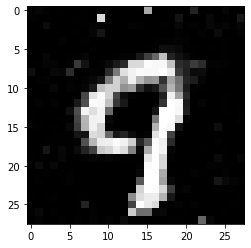

In [27]:
plt.imshow(new_gen_img[0,:,:], cmap = "gray")